In [21]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


# NOTE! There are missing imports here, you will have to add to the imports as you go. 
# I suggest you add all your imports at the top of the notebook. (in this cell)

# California Housing with Linear Regression

In this notebook we will work with a [California Housing Prices Data](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html). 
We are going to use the [Scikit-Learn api](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) to automatically get it. 

Let's load the data and take a look at the information.

This time we will fix up some of our previous mistakes.

In [2]:
housing = fetch_california_housing(as_frame=True) # as_frame will return pandas dataframes instead of numpy arrays

In [3]:
# Scikit-learn datasets normally have a .DESCR attribute, which will tell you about the dataset.
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [4]:
# it's always a good idea to check the type of your variables (especially if you just loaded them automagically)
type(housing)

sklearn.utils._bunch.Bunch

The datatype `bunch` is used by sklearn to contain their datasets. The documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html). It's easiest to think of it as a dictionary which contains different elements of the dataset. So the most basic operation you will want to do is to print the `.keys()` in order to see what elements are available for access.

In [5]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [6]:
# set X to be the data. X is uppercase because it represents a matrix
# since we used as_frame=True, housing.data is a pandas dataframe
X = housing.data
# set y to be the target labels. y is lowercase because it represents a vector.
# since we used as_frame=True, housing.target is a pandas series
y = housing.target

# Explore the data

The first step of any machine learning project is to explore the data a little bit. We already have a general idea because of the description given to us, but let's dig in a tiny bit more.

In [7]:
# printing the shape of your X matrix is always a good idea.
X.shape

(20640, 8)

We have 20640 samples (housing records) and 8 columns (features).

In [8]:
y.shape

(20640,)

These are the 20640 "labels" or put another way "thing we are interested in predicting".  In this case they are median housing prices, that is the price that the house sold for. From the documentation "The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000)."

Let's put our data into a dataframe with pandas and examine the first 5 rows of each.

In [9]:
# looking at the feature names from the dataframe
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [10]:
y.head()


0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Ok, so we have glanced over the first 5 rows just to get a "feel" for the data, do we notice anything interesting? Well we see that the range of the values for each column is quite different, we need to deal with that. So we can add scaling our data to a list of things to do.  Before we run off and start scaling though, let's perform some basic exploratory data analysis. Our goal here is to visually and statisically examine the dataset and see what pops out at us. 

I think the very first step is to just look at the basic information of the data.


# Checking the general information


In [11]:
X.info() # this is a simple function that will get us some basic info about our dataframe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


The `.info()` function will tell us a lot about our dataframe. We can see the RangeIndex, which basically tells us how many values are in the dataframe, further it will tell us what the datatype of the index is (if it's a datetime index for example). In this case we have a basic index, with 20640 rows. 

Next you can see the names of all the columns, and what `Dtype` they are. The datatype in pandas dataframes are heterogeneous, that means you can have different datatypes for different columns. This is just like your standard database - for the same performance reasons. Note that a numpy array _cannot_ have different datatypes for the different columns, this is a bonus feature that pandas gives us building on top of arrays.

Note that `.info()` gives us a non-null count for each column. I find this helpful when scanning for missing values, but I don't only rely on it.
Then we can also see the memory usage for our dataframe, this can be very helpful when you aren't sure what is hogging all the ram!

## Looking for missing values

In [13]:
# This is one of many ways to check if there are any missing values in the dataset.
X.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Using `.isnull().sum()` is one of many ways to check for missing values. I like it because it will show me the missing values column-wise, however if you have a lot of columns this will be truncated and you will have to do other ways. Note you can add an extra `.sum()` and get a single value of `na`'s.

## Looking deeper with EDA (exploratory data analysis)
Ok, now we have look at 
The kinds of questions we want to be thinking about are:
  *  Are any columns strongly correlated?
  *  Do there appear to be columns that have wide ranges and potential outliers?
  *  If we can understand the features, look for relationships that make logical sense (e.g., price of house vs size of house)

We will look at raw numbers and visualizations now. Raw numbers will generally be summary statistics like the mean, standard deviation, max, min, etc. Visualizations will be things like pairplots, correlation matrices, etc.

I don't think it really matters what you do first, you should just start with what you are more comfortable with.

I am going to start with the numbers, because that is the way that my brain works, I like to see numbers first. However, if you prefer plots first you can skip ahead and then return here.

### `pandas.DataFrame.describe()`

This function is very useful to get some quick intuitions for the dataset that you are working with.  Describe will give you thec ommon statistics of your matrix, the mean, std (standard deviation), min, max, and quantiles.  It's nice to scroll through and see if anything interesting pops out.  Looking through the output below, do you notice anything interesting?

In [14]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Write your thoughts here: 

---
Your answer in here (double click to enter the markdown cell and edit)





--- 



# Plot the histograms

Plot histograms for all the continous variables in the dataframe. Use the `.hist()` dataframe method.
You should experiment with the bin size. Use the `bins=` keyword parameter to try different amounts of bins.
I have given you some extra code below to space out the resulting plot a bit more nicely.


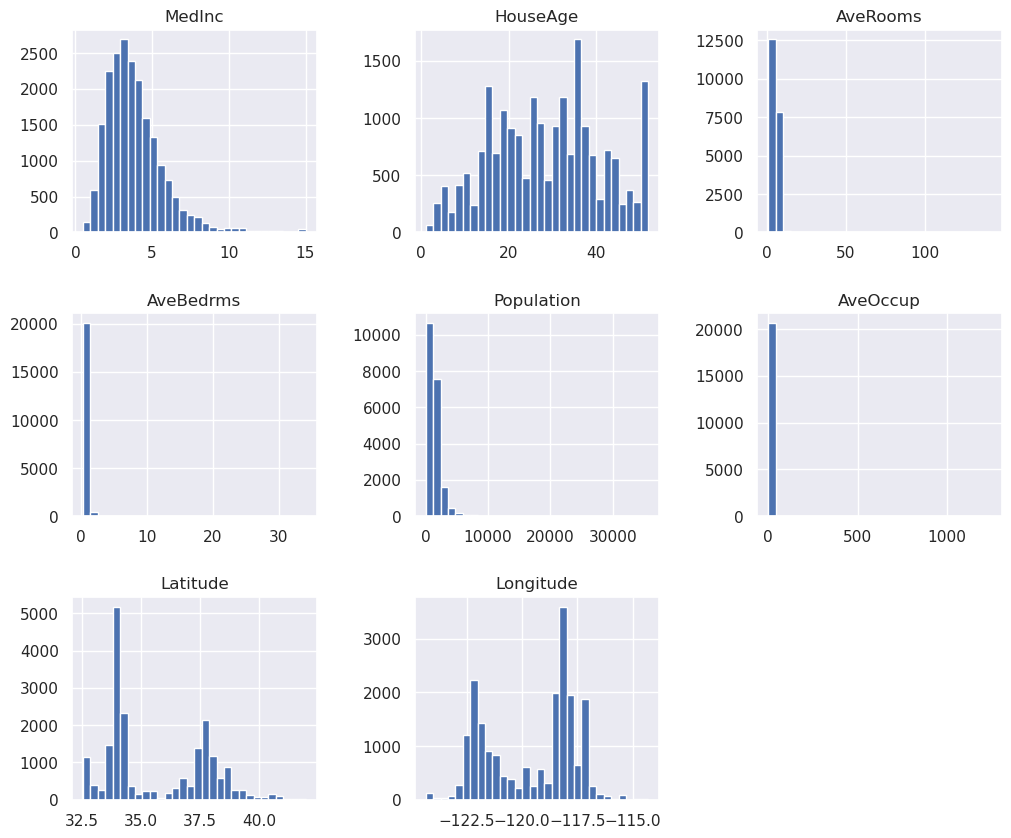

In [15]:
X.hist(figsize=(12, 10), bins=30)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# What do you notice?

What do the distributions tell you about each column?


Write your thoughts here: 

---
Your answer in here (double click to enter the markdown cell and edit)





--- 



### Plot the histograms for the columns that seem only have one value.

Note that some of the histograms seems to only have one column. That is because they are skewed, they have a lot of small values off to the right, they are so small you cannot see them. However, we can zoom in to see the skew.


(0.0, 199.0)

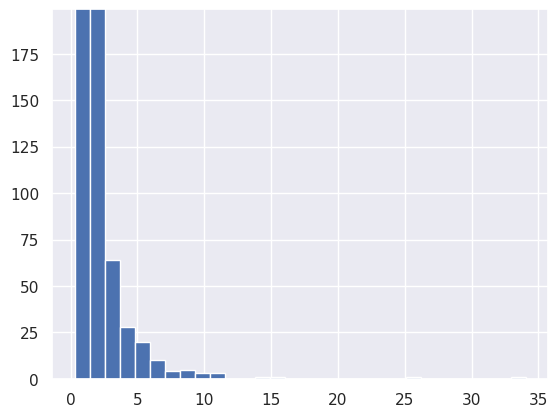

In [16]:

# in order to limit the y-axis we need to expose the axes element
# To get the axes, we will generate one with the subplots command.
fig, ax = plt.subplots()

# select only the column you are interested in from X
# note that we pass ax to the ax keyword. If you don't pass one, pandas will generate it's own.
X['AveBedrms'].hist(bins=30, ax=ax)
# now you can set the y_lim on the axes. 
# play with the top value to zoom in farther and farther
ax.set_ylim(bottom=0, top=199)



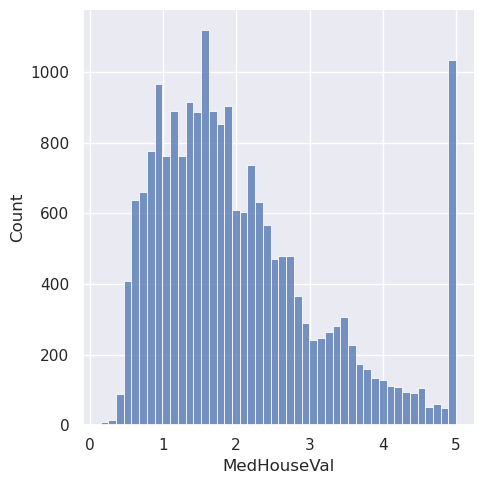

In [17]:
# we should also plot the histogram of the target variable!
sns.displot(y)

## What is that strange single bar above the 5?
When we look at the distribution of the target variable, note that one value seems... a bit too high!
In fact, there is nothing we can really "do" about this, except I personally wonder if they should have made their survey have some higher options on their scale.

# Plotting the longitude and Latitude

One fun thing we can do is to create a scatter plot of the longitude and latitude, while _coloring_ the datapoints according to a hue or gradient of colors. I think it's easiest to let the plot speak for itself so just go ahead and run the code below

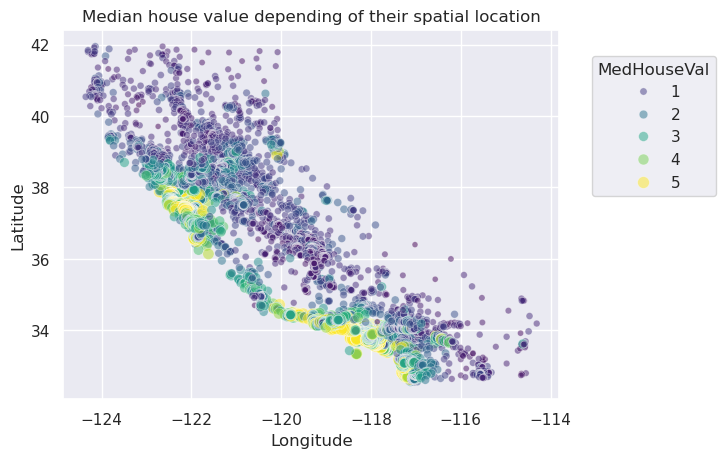

In [18]:
import seaborn as sns

sns.scatterplot(data=X, x="Longitude", y="Latitude",
                size=y, hue=y,
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
plt.title("Median house value depending of their spatial location");

# It looks like a plot of California!
As a California native I can tell you the two dominant yellow spots (expensive!) are the San Franciso bay area and the Los Angeles area. This data is actually pretty old, from before the silicon valley boom. So today I bet this map would be quite different. For those wonder what the small cluster of yellow is in the upper right - that's lake Tahoe - a popular ski resort and beautiful area.

# Pairwise plot
Next we will create what is known as a "pairwise" plot. The idea here is that we want to look at how the features are related to each other. Basically we want to see if they are correlated, if when one feature increases the other feature either goes up or down significantly. So we will do a grid plot where each feature will be compared with every other feature. 

The diagonal axis will produce histograms of the feature (basically the same thing we did early) because we are looking at how the feature interacts with itself.

Using seaborn we can do an extra trick though - we can colorize the plots so that the hue (color pattern) corresponds to our target variable (the price of the house). This is really neat because we can not only see how the features interact with each other, but we get a _third_ dimension which is the target variable. So we in fact are seeing how each feature interacts with the target variable at the same time.


In [19]:
# Drop the unwanted columns
columns_drop = ["Longitude", "Latitude"]
subset = X.drop(columns=columns_drop)
subset["MedHouseVal"]= y

# Quantize the target and keep the midpoint for each interval
# the reason we are doing this is because it makes the plotting of the histograms in pairplot  readable. 
# it will essentially smooth the data, and squish down any wild outliers that cause the axis of the plots to be hard to read.
# if you are curious you can comment out these lines and see the difference.
subset["MedHouseVal"] = pd.qcut(subset["MedHouseVal"], 6, retbins=False)
subset["MedHouseVal"] = subset["MedHouseVal"].apply(lambda x: x.mid)

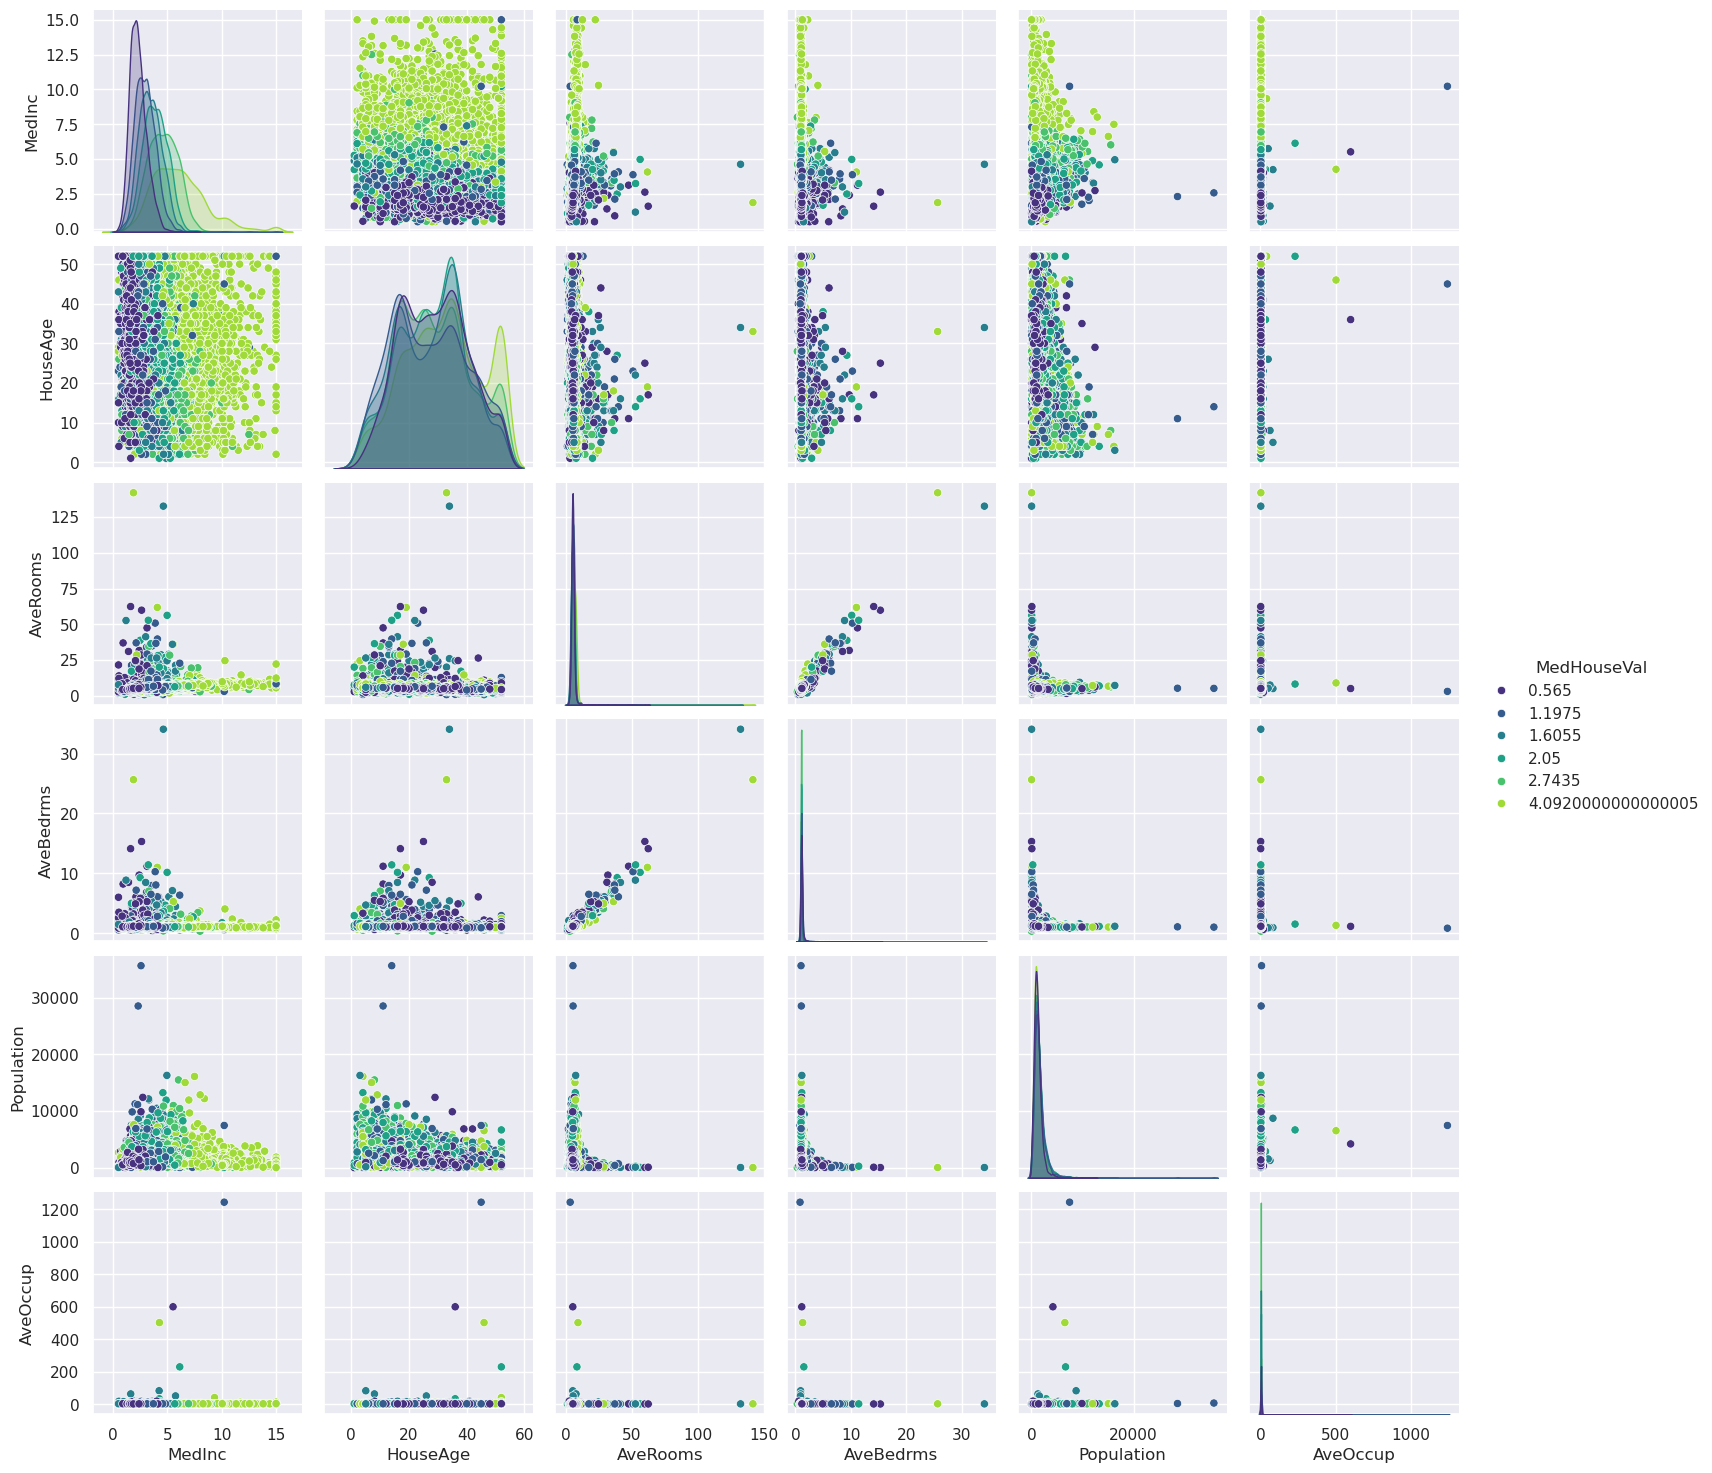

In [20]:
_ = sns.pairplot(data=subset, hue="MedHouseVal", palette="viridis")


# What are your thoughts on the pairplot. What do you notice?

Write your thoughts here: 

---
Your answer in here (double click to enter the markdown cell and edit)





--- 



# Train Test Split

Ok, now we're going to divide up our dataset so that we have an unseen test set that we can evaluate against. This way we can **simulate** tomorrows world and figure out if our trained model can generalize to unseen data at all.

Here is the code to split up our data. It's important to remember how the arrays are passed back, it's always in this exact order, so don't forget!! but if you do forget... you can always look it up [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) (scroll down for the code example).  I have looked it up probably 100 times until I remembered it while teaching this course.

In [39]:
## you need to set the test size!
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .2, random_state=20 ) 

In [40]:
# let's take a look at how many samples we got, just to check.
print(X_train.shape)
print(X_test.shape)

(16512, 8)
(4128, 8)



## Scikit-Learn API 

Many (most?) objects in scikit-learn have a `.fit` method which will tell the model to do whatever it was designed to learn.  From the objects that have a `.fit` method, you will get either a follow up `.transform` or `.predict` method.  Objects with `.transform` are transfromers (like the scaler we just used), their job is to learn some statistics from the data and transform it according to some logic (using the statistics that were learned).  Objects that have a `.predict` method are machine learning algorithms, and when you call `.fit` on them they are going to learn whatever rules / functions that the algorithm is designed to learn. When you call `.predict` with them, they will take as input a data point(s) and give you a prediction(s) for the input.

So, in summary we frequently see three methods

* `.fit` : this tells the object to learn
* `.transform` : this tells the object to apply it's learning in the form a transformation to the input. This method _returns_ an object (the transformed data
* `.predict` : this tells the object to make a prediction on the input, using whatever function the model learned (from the `.fit` call it made earlier)

## Scaling our dataset

Ok, we need to scale our dataset.  We learned about two choices so you can pick from two options!

* StandardScaler
* MinMaxScaler

The order of operations goes like this:
1. initialize a scaler
2. call `fit` on our dataset
3. transform our dataset and return that value to a new variable.

Note: `.fit` and `.transform` are called seperately for some sneaky tricky reasons we will get into a bit later. For now just think to yourself about _why_ sklearn _might_ have seperate `.fit` and `.transform` functions on it's scalers.

In [41]:
## initialize a scaler here

scaler = StandardScaler()# your choice of scaler here (check the imports to remember their names)

In [42]:
## fit your scaler here -- fitting happens "in place" which means it doesn't return anything
## Make sure you only fit on the training data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [43]:
## transform our dataset now and return the value
# you will need to run something like:
# X_scaled = scaler.transform(X_train)

# make sure to transform both the training and testing data
X_test_scaled = scaler.transform(X_test)


In [44]:
scaler.mean_

array([ 3.87177688e+00,  2.86294816e+01,  5.42025158e+00,  1.09534898e+00,
        1.42118453e+03,  3.09737037e+00,  3.56278912e+01, -1.19567038e+02])

In [45]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=housing.feature_names)
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-0.726070,-0.049918,-0.742979,-0.131490,0.462297,-0.067558,-0.800679,0.718815
1,-0.322943,0.267283,-0.082623,-0.178945,-0.391134,-0.047846,-1.306996,1.184006
2,-0.043838,0.980984,-0.618738,-0.408331,-0.741376,0.016575,-0.852249,0.673796
3,-0.669481,1.060284,-0.184007,-0.058783,-0.392944,-0.014535,-0.744422,0.613772
4,0.773735,0.187982,0.010436,-0.354303,-0.354029,-0.015478,-0.833496,0.773838


# Train a model

Ok it's time to train our model.  We will want to choose one of the three options we imported earlier.

* LinearRegression
* SGDRegressor
* Ridge

We are also going to train a [dummy regressor](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html).  This regressor will use a default strategy like 'mean' or 'median'. That means it will always guess the average value in the dataset, which is pretty dumb,b ut we need to prove to ourselves that our model learned something -- so this is a good way to do it.

In [46]:
# initialize a model here
reg = Ridge(random_state=2023)
reg = SGDRegressor()
# intialize your dummy model as well

reg_dummy = DummyRegressor(strategy= 'mean')

In [47]:
# Train your model here with .fit
# make sure that you only .fit on the training data!
reg.fit(X_train_scaled, y_train)
reg_dummy.fit(X_train_scaled, y_train)

,strategy,'mean'
,constant,None
,quantile,None


In [48]:
reg.intercept_

array([2.06011885])

In [49]:
reg.coef_

array([ 0.82750057,  0.11316509, -0.26346434,  0.29746331,  0.00377136,
       -0.15795878, -0.88614742, -0.85896282])

## umm... are we done?
So we fit a model right? Now unlike our previous work, we can't really plot this model, it's not a line in 2d, it's a plane in 13d.  So what can we do?  We need to evaluate our model somehow! What should we do?
How about we make a bunch of predictions and see what kind of accuracy it gets?  We can evaluate it's mean-squared error, the same metric we used to optimize it.

# Evaluate our model

Ok, let's use our trained model to make predictions, then we can evaluate those predictions against the real known `y` values. You will need to use your models `.predict()` function which needs some input to predict on.

In [51]:
## use your model to make predictions on the data
# you will need to run something like:
# y_pred = model.predict(testing data) - but you will need to use the model you trained above. 
# also, consider carefully what X data you should be using here 

y_pred = reg.predict(X_test_scaled)
dumb_y_preds = reg_dummy.predict(X_test_scaled)

/home/liorc/miniconda3/envs/cn_ml_course/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(


Ok now we need to evaluate our predictions. We will use scikit-learns inbuilt mean squared error metric for this. It's very important that you pass your arguments correctly to the evaluation function, all scikit-learn metrics use `y_true, y_pred` format, which means pass the ground-truth first, followed by the prediction.

## Evaluate both the training performance AND the testing performance.

It's important to evaluate your models performance on both the training and testing datasets.
Comparing the difference (or lack of difference) between training and testing performance can yield a lot of insight into your models behavior.


In [54]:
# now you need to evaluate your model.
# you can use the mean squared error and the r2 score to do this.
# you can import these from sklearn.metrics
# remember that you need both predictions and ground truth to evaluate your model.
reg_score = mean_squared_error(y_test, y_pred)
dummy_score = mean_squared_error(y_test,dumb_y_preds)
print(f"The MSE of our regressor on the testing data: {np.sqrt(reg_score):.3f}")
print(f"The MSE of our dummy on the testing data: {np.sqrt(dummy_score):.3f}")

The MSE of our regressor on the testing data: 0.732
The MSE of our dummy on the testing data: 1.181


In [56]:
train_preds = reg.predict(X_train_scaled)
reg_score_tr = mean_squared_error(y_train, train_preds)
print(f"The MSE of our regressor on the testing data: {np.sqrt(reg_score_tr):.3f}")


The MSE of our regressor on the testing data: 0.731


### Automate model production
Let's build more models and automate the evaluation with a for loop.

In [57]:
# three models to try out - setting them all on defaults (you may need to add imports!)
reg_ridge = Ridge(random_state=2023)
reg_SGD = SGDRegressor(random_state=2023)
reg_Linear = LinearRegression()

In [58]:
# put them in a list and loop over them
regs= [reg_ridge, reg_SGD, reg_Linear]

In [61]:
# Write some code that will take your list and then iterate over each model
# and print out the MSE and R2 score for each model.
# you can use the __class__ attribute to automatically get the name of the model you are using.
for reg in regs:
    reg.fit(X_train_scaled, y_train)
    class_name = {reg.__class__}

    y_pred = reg.predict(X_train_scaled)
    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)

    print(f"Training scores for {class_name}")
    print(f"The training MSE is {mse:.3f}")
    print(f"The training r2 is {r2:.3f}")
    print()

    print(f"Testing scores for {class_name}")
    y_pred = reg.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"The testing MSE is {mse:.3f}")
    print(f"The testing r2 is {r2:.3f}")
    print()
    print("--------Next Model------")

Training scores for {<class 'sklearn.linear_model._ridge.Ridge'>}
The training MSE is 0.521
The training r2 is 0.604

Testing scores for {<class 'sklearn.linear_model._ridge.Ridge'>}
The testing MSE is 0.541
The testing r2 is 0.612

--------Next Model------
Training scores for {<class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>}
The training MSE is 0.525
The training r2 is 0.601

Testing scores for {<class 'sklearn.linear_model._stochastic_gradient.SGDRegressor'>}
The testing MSE is 0.538
The testing r2 is 0.615

--------Next Model------
Training scores for {<class 'sklearn.linear_model._base.LinearRegression'>}
The training MSE is 0.521
The training r2 is 0.604

Testing scores for {<class 'sklearn.linear_model._base.LinearRegression'>}
The testing MSE is 0.541
The testing r2 is 0.612

--------Next Model------


/home/liorc/miniconda3/envs/cn_ml_course/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/home/liorc/miniconda3/envs/cn_ml_course/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDRegressor was fitted with feature names
  warnings.warn(
/home/liorc/miniconda3/envs/cn_ml_course/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(



Make sure that you are getting predictions on BOTH training and testing data. 
Evaluate the performance on both sets of data.
This is called "training performance" and "testing performance"


# Are we happy with these scores?
The R2 ranges between 0-1 , 1 being very correlated (and good in our case). 
For the MSE, it's instructive to look at the square root, which will be the real average error.

In [62]:
np.sqrt(0.5243210444129816) #your mse value in here


np.float64(0.724100161865043)

Is this a good MSE, Does the +/- seem good? Well it depends, we have to look at what that means in terms of the target variable.  When we plotted the distribution we saw that the target variable is between 0-5, so in general we are off by.. you tell me!

Compared to the Dummy model how did it do?

In general, I don't think we'll be taking this model to the market to make a living as a real estate agent!


## That's a wrap!

Any issues? Are we happy with everything?